<a href="https://colab.research.google.com/github/zayneb-n/hybrid-recommendation-system-/blob/master/Hybrid_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving amazon.csv to amazon.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv("/content/amazon.csv")

In [4]:
print(data.head())
print(data.info())

   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   
3  B08HDJ86NZ  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...   
4  B08CF3B7N1  Portronics Konnect L 1.2M Fast Charging 3A 8 P...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             ₹399   
1  Computers&Accessories|Accessories&Peripherals|...             ₹199   
2  Computers&Accessories|Accessories&Peripherals|...             ₹199   
3  Computers&Accessories|Accessories&Peripherals|...             ₹329   
4  Computers&Accessories|Accessories&Peripherals|...             ₹154   

  actual_price discount_percentage rating rating_count  \
0       ₹1,099                 64%    4.2       24,269   
1         ₹349                 43%  

In [5]:
data = data.dropna(subset=['rating', 'rating_count'])

In [6]:
data['rating'] = pd.to_numeric(data['rating'], errors='coerce')
# Ensure valid ratings
data = data[data['rating'] > 0]

In [7]:
# Clean 'discounted_price' by removing '₹' and commas, then convert to numeric
data['discounted_price'] = data['discounted_price'].str.replace('₹', '', regex=False).str.replace(',', '', regex=False)
data['discounted_price'] = pd.to_numeric(data['discounted_price'], errors='coerce')

In [8]:
# Clean 'rating_count' by removing commas and convert to numeric
data['rating_count'] = data['rating_count'].str.replace(',', '', regex=False)
data['rating_count'] = pd.to_numeric(data['rating_count'], errors='coerce')

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the ratings and prices
scaler = MinMaxScaler()
data['normalized_rating'] = scaler.fit_transform(data[['rating']])
data['normalized_price'] = scaler.fit_transform(data[['discounted_price']])

In [11]:
# Encode 'user_id' and 'product_id'
# Since 'user_id' and 'product_id' contain multiple entries separated by commas, we need to handle them
data = data.explode('user_id')  # Split 'user_id' by commas into individual rows
data['user_id_encoded'] = data['user_id'].astype('category').cat.codes
data['product_id_encoded'] = data['product_id'].astype('category').cat.codes

# Ensure numeric types for 'user_id_encoded' and 'product_id_encoded'
data['user_id_encoded'] = pd.to_numeric(data['user_id_encoded'], errors='coerce')
data['product_id_encoded'] = pd.to_numeric(data['product_id_encoded'], errors='coerce')

# Check the number of unique users and products
n_users = data['user_id_encoded'].nunique()
n_products = data['product_id_encoded'].nunique()

print(f"Number of users: {n_users}")
print(f"Number of products: {n_products}")

Number of users: 1191
Number of products: 1348


In [12]:
# Split the data into training and testing sets
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [13]:
# Prepare training and testing inputs
train_user = train['user_id_encoded'].values
train_product = train['product_id_encoded'].values
train_rating = train['normalized_rating'].values

test_user = test['user_id_encoded'].values
test_product = test['product_id_encoded'].values
test_rating = test['normalized_rating'].values

# Check sizes
print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")

Training set size: 1169
Testing set size: 293


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# User and Product Embedding Layers
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=n_users, output_dim=50, embeddings_regularizer=l2(0.01), name='user_embedding')(user_input)
user_vector = Flatten(name='user_vector')(user_embedding)
user_vector = Dropout(0.2, name='user_dropout')(user_vector)

product_input = Input(shape=(1,), name='product_input')
product_embedding = Embedding(input_dim=n_products, output_dim=50, embeddings_regularizer=l2(0.01), name='product_embedding')(product_input)
product_vector = Flatten(name='product_vector')(product_embedding)
product_vector = Dropout(0.2, name='product_dropout')(product_vector)

# Dot Product to Combine User and Product Features
dot_product = Dot(axes=1, name='dot_product')([user_vector, product_vector])

# Output Layer for Regression (Rating Prediction)
output = Dense(1, name='output')(dot_product)

# Compile the Model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 50)          │         59,550 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_embedding         │ (None, 1, 50)          │         67,400 │ product_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_vector (Flatten)     │ (None, 50)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_vector (Flatten)  │ (None, 50)             │              0 │ product_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_dropout (Dropout)    │ (None, 50)             │              0 │ user_vector[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_dropout (Dropout) │ (None, 50)             │              0 │ product_vector[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_product (Dot)         │ (None, 1)              │              0 │ user_dropout[0][0],    │
│                           │                        │                │ product_dropout[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │              2 │ dot_product[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 126,952 (495.91 KB)

 Trainable params: 126,952 (495.91 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping to Prevent Overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    [train_user, train_product],
    train_rating,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 1.5195 - mae: 0.7022 - val_loss: 1.3814 - val_mae: 0.6945
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3476 - mae: 0.6960 - val_loss: 1.2326 - val_mae: 0.6915
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2096 - mae: 0.6978 - val_loss: 1.1056 - val_mae: 0.6885
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0816 - mae: 0.6895 - val_loss: 0.9971 - val_mae: 0.6855
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9815 - mae: 0.6897 - val_loss: 0.9045 - val_mae: 0.6825
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8835 - mae: 0.6806 - val_loss: 0.8257 - val_mae: 0.6795
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8193 - mae: 0.6868 - val_loss: 0.7587 - val_mae: 0.6765
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7505 - mae: 0.6807 - val_loss: 0.7019 - val_mae: 0.6736
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6935 - mae

In [16]:
# Evaluate the Model on Test Data
results = model.evaluate([test_user, test_product], test_rating, batch_size=32)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3089 - mae: 0.5476
Test Loss (MSE): 0.3085
Test MAE: 0.5472


In [17]:
# Predict ratings for a few user-product pairs
sample_user = test_user[:5]
sample_product = test_product[:5]

predicted_ratings = model.predict([sample_user, sample_product])
print("Predicted Ratings:", predicted_ratings.flatten())

# Compare with actual ratings
actual_ratings = test_rating[:5]
print("Actual Ratings:", actual_ratings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
Predicted Ratings: [0.1430646  0.14306459 0.14306459 0.14306459 0.14306459]
Actual Ratings: [0.8        0.76666667 0.5        0.7        0.66666667]


In [18]:
print(f"Normalized Ratings Range: {train_rating.min()} to {train_rating.max()}")

Normalized Ratings Range: 0.0 to 0.9999999999999999


In [19]:
train_rating = train_rating / train_rating.max()
test_rating = test_rating / test_rating.max()

In [20]:
print(f"Average interactions per user: {len(data) / n_users}")
print(f"Average interactions per product: {len(data) / n_products}")

Average interactions per user: 1.2275398824517212
Average interactions per product: 1.0845697329376855


In [21]:
# Extract embeddings from the trained model
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
product_embeddings = model.get_layer('product_embedding').get_weights()[0]

print("User Embeddings Shape:", user_embeddings.shape)
print("Product Embeddings Shape:", product_embeddings.shape)

# Inspect a sample of user and product embeddings
print("Sample User Embeddings:", user_embeddings[:5])
print("Sample Product Embeddings:", product_embeddings[:5])

User Embeddings Shape: (1191, 50)
Product Embeddings Shape: (1348, 50)
Sample User Embeddings: [[-6.22291761e-38  3.01611720e-07  8.28165986e-13  4.45567103e-08
   1.07205705e-34 -2.74147016e-08 -5.87619509e-10 -1.19175602e-05
   5.31859637e-38  1.00931898e-32  1.85128793e-05  1.30512962e-10
   1.31649374e-22 -1.60444415e-05  8.48098901e-39  6.30274403e-34
   9.70783434e-37  6.97356965e-37  3.26892905e-06 -1.94924869e-05
   3.28466704e-05 -1.73265129e-37  5.37828670e-11  1.70122387e-37
  -1.19256383e-05  2.34731951e-31 -3.20373729e-05 -2.64156931e-36
  -1.66579437e-32 -3.64130769e-38 -1.03566490e-05  1.07243024e-34
   2.62686708e-08  1.04100454e-05 -1.11589384e-12  1.42581452e-35
  -7.81602638e-21  1.46555195e-08 -9.49709467e-09  9.56562844e-17
  -7.80358167e-10 -6.29634144e-07 -1.75403019e-12  4.14344395e-05
  -5.94548908e-07 -2.85302272e-12  9.35767130e-10 -3.81841375e-36
   1.39663234e-06 -8.91242235e-06]
 [-3.25963847e-05 -2.11560587e-06 -5.74482755e-08  6.05633003e-23
   1.8835887

In [22]:
from tensorflow.keras.initializers import he_normal

# Adjust embedding dimensions and initialization
user_embedding = Embedding(input_dim=n_users, output_dim=100, embeddings_initializer=he_normal())(user_input)
product_embedding = Embedding(input_dim=n_products, output_dim=100, embeddings_initializer=he_normal())(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

dot_product = Dot(axes=1)([user_vector, product_vector])
interaction = Dense(64, activation='relu')(dot_product)
interaction = Dense(32, activation='relu')(interaction)
output = Dense(1)(interaction)

# Compile and train the model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history = model.fit(
    [train_user, train_product],
    train_rating,
    validation_split=0.2,
    epochs=200,
    batch_size=32
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.4014 - mae: 0.6199 - val_loss: 0.0766 - val_mae: 0.2637
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0363 - mae: 0.1609 - val_loss: 0.0101 - val_mae: 0.0720
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - mae: 0.0741 - val_loss: 0.0087 - val_mae: 0.0705
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - mae: 0.0575 - val_loss: 0.0090 - val_mae: 0.0715
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mae: 0.0337 - val_loss: 0.0104 - val_mae: 0.0769
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0590e-04 - mae: 0.0169 - val_loss: 0.0100 - val_mae: 0.0745
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5455e-04 - mae: 0.0115 - val_loss: 0.0107 - val_mae: 0.0772
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9562e-04 - mae: 0.0075 - val_loss: 0.0103 - val_mae: 0.0757
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

In [23]:
results = model.evaluate([test_user, test_product], test_rating, batch_size=32)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0175 - mae: 0.1146
Test Loss (MSE): 0.0179
Test MAE: 0.1158


In [24]:
predicted_ratings = model.predict([test_user[:5], test_product[:5]])
print("Predicted Ratings:", predicted_ratings.flatten())
print("Actual Ratings:", test_rating[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
Predicted Ratings: [0.7988311  0.6643402  0.65444094 0.6537242  0.6641119 ]
Actual Ratings: [0.88888889 0.85185185 0.55555556 0.77777778 0.74074074]


In [25]:
from tensorflow.keras.layers import BatchNormalization, Dropout

# Adjust embedding dimensions and initialization
user_embedding = Embedding(input_dim=n_users, output_dim=100, embeddings_initializer=he_normal())(user_input)
product_embedding = Embedding(input_dim=n_products, output_dim=100, embeddings_initializer=he_normal())(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

# Dot product of user and product embeddings
dot_product = Dot(axes=1)([user_vector, product_vector])

# Additional dense layers with batch normalization and dropout for stability
interaction = Dense(64, activation='relu')(dot_product)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.2)(interaction)  # Slight regularization

interaction = Dense(32, activation='relu')(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.2)(interaction)  # Slight regularization

output = Dense(1)(interaction)

# Compile the model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    [train_user, train_product],
    train_rating,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 1.3831 - mae: 0.9327 - val_loss: 0.2136 - val_mae: 0.4539
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.8606 - mae: 0.7158 - val_loss: 0.0737 - val_mae: 0.2581
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5917 - mae: 0.5795 - val_loss: 0.0254 - val_mae: 0.1414
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5468 - mae: 0.4844 - val_loss: 0.0148 - val_mae: 0.1019
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3669 - mae: 0.3712 - val_loss: 0.0116 - val_mae: 0.0869
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3110 - mae: 0.3467 - val_loss: 0.0101 - val_mae: 0.0795
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3117 - mae: 0.3446 - val_loss: 0.0087 - val_mae: 0.0708
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1620 - mae: 0.2585 - val_loss: 0.0087 - val_mae: 0.0688
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2

In [26]:
# Evaluate the model
results = model.evaluate([test_user, test_product], test_rating, batch_size=32)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0161 - mae: 0.1080
Test Loss (MSE): 0.0161
Test MAE: 0.1076


In [27]:
predicted_ratings = model.predict([test_user[:5], test_product[:5]])
print("Predicted Ratings:", predicted_ratings.flatten())
print("Actual Ratings:", test_rating[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
Predicted Ratings: [0.6927917  0.6965544  0.6969667  0.6954399  0.69738686]
Actual Ratings: [0.88888889 0.85185185 0.55555556 0.77777778 0.74074074]


it's quite good but prone to enhancements

In [35]:
# slightly increased dimensions
user_embedding = Embedding(input_dim=n_users, output_dim=150, embeddings_initializer=he_normal(), name='user_embedding')(user_input)
product_embedding = Embedding(input_dim=n_products, output_dim=150, embeddings_initializer=he_normal(),  name='product_embedding')(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

# Dot product of user and product embeddings
dot_product = Dot(axes=1)([user_vector, product_vector])

# Additional dense layers with batch normalization and reduced dropout
interaction = Dense(128, activation='relu')(dot_product)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

interaction = Dense(64, activation='relu')(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

interaction = Dense(32, activation='relu')(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

output = Dense(1)(interaction)

# Compile the model with a smaller learning rate
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    [train_user, train_product],
    train_rating,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 1.3940 - mae: 0.9149 - val_loss: 0.2761 - val_mae: 0.5178
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8228 - mae: 0.7292 - val_loss: 0.1084 - val_mae: 0.3183
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5642 - mae: 0.5977 - val_loss: 0.0309 - val_mae: 0.1586
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4895 - mae: 0.5521 - val_loss: 0.0090 - val_mae: 0.0731
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3946 - mae: 0.4862 - val_loss: 0.0117 - val_mae: 0.0792
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2879 - mae: 0.4071 - val_loss: 0.0203 - val_mae: 0.1127
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3036 - mae: 0.4162 - val_loss: 0.0267 - val_mae: 0.1357
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2994 - mae: 0.3886 - val_loss: 0.0358 - val_mae: 0.1648
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2

In [36]:
# Evaluate the model
results = model.evaluate([test_user, test_product], test_rating, batch_size=32)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0190 - mae: 0.1198
Test Loss (MSE): 0.0190
Test MAE: 0.1193


In [37]:
predicted_ratings = model.predict([test_user[:5], test_product[:5]])
print("Predicted Ratings:", predicted_ratings.flatten())
print("Actual Ratings:", test_rating[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
Predicted Ratings: [0.6760903  0.67864454 0.67947847 0.6793559  0.6770546 ]
Actual Ratings: [0.88888889 0.85185185 0.55555556 0.77777778 0.74074074]


In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Slightly increased embedding dimensions
user_embedding = Embedding(input_dim=n_users, output_dim=150, embeddings_initializer=he_normal(), name='user_embedding')(user_input)
product_embedding = Embedding(input_dim=n_products, output_dim=150, embeddings_initializer=he_normal(), name='product_embedding')(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

# Dot product of user and product embeddings
dot_product = Dot(axes=1)([user_vector, product_vector])

# Additional dense layers with batch normalization and tuned dropout
interaction = Dense(128, activation='relu')(dot_product)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.2)(interaction)

interaction = Dense(64, activation='relu')(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.2)(interaction)

interaction = Dense(32, activation='relu')(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.2)(interaction)

interaction = Dense(16, activation='relu')(interaction)  # Additional dense layer
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)  # Slightly lower dropout for the last layer

output = Dense(1)(interaction)

# Compile the model with a learning rate scheduler
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler to dynamically reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    [train_user, train_product],
    train_rating,
    validation_split=0.2,
    epochs=200,
    batch_size=16,  # Smaller batch size for better gradient updates
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 1.5235 - mae: 0.9775 - val_loss: 0.4644 - val_mae: 0.6751 - learning_rate: 0.0010
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6813 - mae: 0.6653 - val_loss: 0.2846 - val_mae: 0.5260 - learning_rate: 0.0010
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3984 - mae: 0.4905 - val_loss: 0.0940 - val_mae: 0.2946 - learning_rate: 0.0010
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2982 - mae: 0.4257 - val_loss: 0.0532 - val_mae: 0.2148 - learning_rate: 0.0010
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2537 - mae: 0.3907 - val_loss: 0.0282 - val_mae: 0.1476 - learning_rate: 0.0010
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2703 - mae: 0.3983 - val_loss: 0.0191 - val_mae: 0.1148 - learning_rate: 0.0010
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1550 - mae: 0.3080 - val_loss: 0.0160 - val_mae: 0.1016 - learning_rate: 0.0010
Epoch 8/200

In [39]:
# Evaluate the model
results = model.evaluate([test_user, test_product], test_rating, batch_size=16)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0286 - mae: 0.1505
Test Loss (MSE): 0.0287
Test MAE: 0.1509


In [40]:
# Embedding layers with meaningful names
user_embedding = Embedding(input_dim=n_users, output_dim=150, embeddings_initializer=he_normal(), name='user_embedding')(user_input)
product_embedding = Embedding(input_dim=n_products, output_dim=150, embeddings_initializer=he_normal(), name='product_embedding')(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

# Dot product of user and product embeddings
dot_product = Dot(axes=1)([user_vector, product_vector])

# Dense layers with slight regularization
interaction = Dense(128, activation='relu')(dot_product)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

interaction = Dense(64, activation='relu')(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

interaction = Dense(32, activation='relu')(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

output = Dense(1)(interaction)

# Compile the model with the same learning rate
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    [train_user, train_product],
    train_rating,
    validation_split=0.2,
    epochs=200,
    batch_size=32,  # Stick to the previous batch size
    callbacks=[early_stopping]
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 1.9589 - mae: 1.1050 - val_loss: 0.3614 - val_mae: 0.5939
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0066 - mae: 0.8040 - val_loss: 0.2174 - val_mae: 0.4581
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6682 - mae: 0.6492 - val_loss: 0.1267 - val_mae: 0.3457
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5214 - mae: 0.5654 - val_loss: 0.0558 - val_mae: 0.2215
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4770 - mae: 0.5271 - val_loss: 0.0279 - val_mae: 0.1492
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4096 - mae: 0.5042 - val_loss: 0.0132 - val_mae: 0.0935
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3464 - mae: 0.4445 - val_loss: 0.0098 - val_mae: 0.0770
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2804 - mae: 0.3979 - val_loss: 0.0100 - val_mae: 0.0726
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

In [41]:
# Evaluate the model
results = model.evaluate([test_user, test_product], test_rating, batch_size=32)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0210 - mae: 0.1266
Test Loss (MSE): 0.0210
Test MAE: 0.1263


In [42]:
from tensorflow.keras.regularizers import l2

# Slightly increased embedding dimensions
user_embedding = Embedding(input_dim=n_users, output_dim=175, embeddings_initializer=he_normal(), name='user_embedding')(user_input)
product_embedding = Embedding(input_dim=n_products, output_dim=175, embeddings_initializer=he_normal(), name='product_embedding')(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

# Dot product of user and product embeddings
dot_product = Dot(axes=1)([user_vector, product_vector])

# Dense layers with weight regularization and batch normalization
interaction = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dot_product)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

interaction = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

interaction = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

# Output layer with activation
output = Dense(1, activation='sigmoid')(interaction)

# Compile the model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    [train_user, train_product],
    train_rating,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 1.3694 - mae: 0.2606 - val_loss: 1.1574 - val_mae: 0.1554
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1529 - mae: 0.2189 - val_loss: 0.9703 - val_mae: 0.1116
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9655 - mae: 0.1818 - val_loss: 0.8119 - val_mae: 0.0836
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8135 - mae: 0.1713 - val_loss: 0.6799 - val_mae: 0.0713
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6811 - mae: 0.1514 - val_loss: 0.5706 - val_mae: 0.0692
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5695 - mae: 0.1398 - val_loss: 0.4794 - val_mae: 0.0707
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4794 - mae: 0.1347 - val_loss: 0.4038 - val_mae: 0.0752
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3991 - mae: 0.1205 - val_loss: 0.3398 - val_mae: 0.0771
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0

In [43]:
# Evaluate the model
results = model.evaluate([test_user, test_product], test_rating, batch_size=32)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0191 - mae: 0.1079
Test Loss (MSE): 0.0189
Test MAE: 0.1063


In [44]:
predicted_ratings = model.predict([test_user[:5], test_product[:5]])
print("Predicted Ratings:", predicted_ratings.flatten())
print("Actual Ratings:", test_rating[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Predicted Ratings: [0.74305546 0.68588394 0.67552966 0.69003993 0.7680935 ]
Actual Ratings: [0.88888889 0.85185185 0.55555556 0.77777778 0.74074074]


While it's competitive to earlier model but let's keep the previous approach

In [49]:
from tensorflow.keras.regularizers import l2

# Slightly increased embedding dimensions
user_embedding = Embedding(input_dim=n_users, output_dim=175, embeddings_initializer=he_normal(), name='user_embedding')(user_input)
product_embedding = Embedding(input_dim=n_products, output_dim=175, embeddings_initializer=he_normal(), name='product_embedding')(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

# Dot product of user and product embeddings
dot_product = Dot(axes=1)([user_vector, product_vector])

# Dense layers with weight regularization and batch normalization
interaction = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dot_product)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

interaction = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

interaction = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

# Output layer with activation
output = Dense(1, activation='sigmoid')(interaction)

# Compile the model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    [train_user, train_product],
    train_rating,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 1.3486 - mae: 0.2443 - val_loss: 1.1559 - val_mae: 0.1831
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1436 - mae: 0.2091 - val_loss: 0.9835 - val_mae: 0.1600
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9712 - mae: 0.1874 - val_loss: 0.8344 - val_mae: 0.1415
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8201 - mae: 0.1658 - val_loss: 0.7048 - val_mae: 0.1222
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6925 - mae: 0.1527 - val_loss: 0.5942 - val_mae: 0.1050
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5870 - mae: 0.1458 - val_loss: 0.5016 - val_mae: 0.0921
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4945 - mae: 0.1258 - val_loss: 0.4238 - val_mae: 0.0852
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4201 - mae: 0.1217 - val_loss: 0.3580 - val_mae: 0.0755
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

In [50]:
# Evaluate the model
results = model.evaluate([test_user, test_product], test_rating, batch_size=32)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0191 - mae: 0.0993
Test Loss (MSE): 0.0191
Test MAE: 0.0990


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
Predicted Ratings: [0.7574454  0.64975655 0.6632245  0.71623963 0.7407543 ]
Actual Ratings: [0.88888889 0.85185185 0.55555556 0.77777778 0.74074074]


Refined back to best perf one 150 dimensions for embeddings.
No L2 regularization in dense layers.
No sigmoid activation in the output layer.



In [52]:
# Embedding layers
user_embedding = Embedding(input_dim=n_users, output_dim=150, embeddings_initializer=he_normal(), name='user_embedding')(user_input)
product_embedding = Embedding(input_dim=n_products, output_dim=150, embeddings_initializer=he_normal(), name='product_embedding')(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

# Dot product of user and product embeddings
dot_product = Dot(axes=1)([user_vector, product_vector])

# Dense layers with batch normalization and dropout
interaction = Dense(128, activation='relu')(dot_product)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

interaction = Dense(64, activation='relu')(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

interaction = Dense(32, activation='relu')(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

# Output layer
output = Dense(1)(interaction)

# Compile the model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    [train_user, train_product],
    train_rating,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 1.1398 - mae: 0.8747 - val_loss: 0.6568 - val_mae: 0.8051
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6666 - mae: 0.6739 - val_loss: 0.8239 - val_mae: 0.9029
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4993 - mae: 0.5891 - val_loss: 0.9377 - val_mae: 0.9639
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4256 - mae: 0.5342 - val_loss: 0.9438 - val_mae: 0.9670
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3643 - mae: 0.4868 - val_loss: 0.8856 - val_mae: 0.9365
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2631 - mae: 0.4114 - val_loss: 0.8072 - val_mae: 0.8937


In [53]:
# Evaluate the model
results = model.evaluate([test_user, test_product], test_rating, batch_size=32)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.7768 - mae: 0.8750
Test Loss (MSE): 0.7761
Test MAE: 0.8746


In [54]:
# Embedding layers
user_embedding = Embedding(input_dim=n_users, output_dim=150, embeddings_initializer=he_normal(), name='user_embedding')(user_input)
product_embedding = Embedding(input_dim=n_products, output_dim=150, embeddings_initializer=he_normal(), name='product_embedding')(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

# Dot product of user and product embeddings
dot_product = Dot(axes=1)([user_vector, product_vector])

# Dense layers with L2 regularization and batch normalization
interaction = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dot_product)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

interaction = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

interaction = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.1)(interaction)

# Output layer with sigmoid activation
output = Dense(1, activation='sigmoid')(interaction)

# Compile the model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    [train_user, train_product],
    train_rating,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 1.3519 - mae: 0.2468 - val_loss: 1.1651 - val_mae: 0.2120
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1360 - mae: 0.2142 - val_loss: 0.9947 - val_mae: 0.2281
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9448 - mae: 0.1771 - val_loss: 0.8457 - val_mae: 0.2373
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7929 - mae: 0.1710 - val_loss: 0.7131 - val_mae: 0.2333
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6563 - mae: 0.1450 - val_loss: 0.5968 - val_mae: 0.2202
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5474 - mae: 0.1346 - val_loss: 0.5006 - val_mae: 0.2109
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4526 - mae: 0.1220 - val_loss: 0.4151 - val_mae: 0.1893
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3815 - mae: 0.1198 - val_loss: 0.3503 - val_mae: 0.1843
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3

In [55]:
# Evaluate the model
results = model.evaluate([test_user, test_product], test_rating, batch_size=32)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0173 - mae: 0.1025
Test Loss (MSE): 0.0172
Test MAE: 0.1010


In [56]:
model.save('collaborativefiltering.h5')

In [57]:
# Slightly tweaked embedding dimensions
user_embedding = Embedding(input_dim=n_users, output_dim=160, embeddings_initializer=he_normal(), name='user_embedding')(user_input)
product_embedding = Embedding(input_dim=n_products, output_dim=160, embeddings_initializer=he_normal(), name='product_embedding')(product_input)

user_vector = Flatten()(user_embedding)
product_vector = Flatten()(product_embedding)

# Dot product of user and product embeddings
dot_product = Dot(axes=1)([user_vector, product_vector])

# Dense layers with L2 regularization and adjusted dropout
interaction = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dot_product)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.15)(interaction)

interaction = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.15)(interaction)

interaction = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(interaction)
interaction = BatchNormalization()(interaction)
interaction = Dropout(0.15)(interaction)

interaction = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(interaction)  # New dense layer
interaction = BatchNormalization()(interaction)

# Output layer with sigmoid activation
output = Dense(1, activation='sigmoid')(interaction)

# Compile the model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    [train_user, train_product],
    train_rating,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - loss: 1.5293 - mae: 0.2418 - val_loss: 1.3251 - val_mae: 0.1955 - learning_rate: 5.0000e-04
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.3004 - mae: 0.2184 - val_loss: 1.1329 - val_mae: 0.1855 - learning_rate: 5.0000e-04
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1061 - mae: 0.1993 - val_loss: 0.9667 - val_mae: 0.1772 - learning_rate: 5.0000e-04
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9358 - mae: 0.1733 - val_loss: 0.8214 - val_mae: 0.1650 - learning_rate: 5.0000e-04
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7943 - mae: 0.1612 - val_loss: 0.6964 - val_mae: 0.1528 - learning_rate: 5.0000e-04
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6706 - mae: 0.1412 - val_loss: 0.5901 - val_mae: 0.1397 - learning_rate: 5.0000e-04
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5677 - mae: 0.1284 - val_loss: 0.4998 - val_mae: 0.1283 - learning

In [58]:
results = model.evaluate([test_user, test_product], test_rating, batch_size=32)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0183 - mae: 0.1043
Test Loss (MSE): 0.0183
Test MAE: 0.1045


In [59]:
predicted_ratings = model.predict([test_user[:5], test_product[:5]])
print("Predicted Ratings:", predicted_ratings.flatten())
print("Actual Ratings:", test_rating[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Ratings: [0.7397072  0.6714035  0.70467013 0.71027917 0.72983134]
Actual Ratings: [0.88888889 0.85185185 0.55555556 0.77777778 0.74074074]


#We will proceed with the saved model

In [62]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError

# Reload the saved model
model = load_model('collaborativefiltering.h5', custom_objects={'mse': MeanSquaredError()})

In [63]:
# Recompile the model after loading
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Visualizing Embeddings

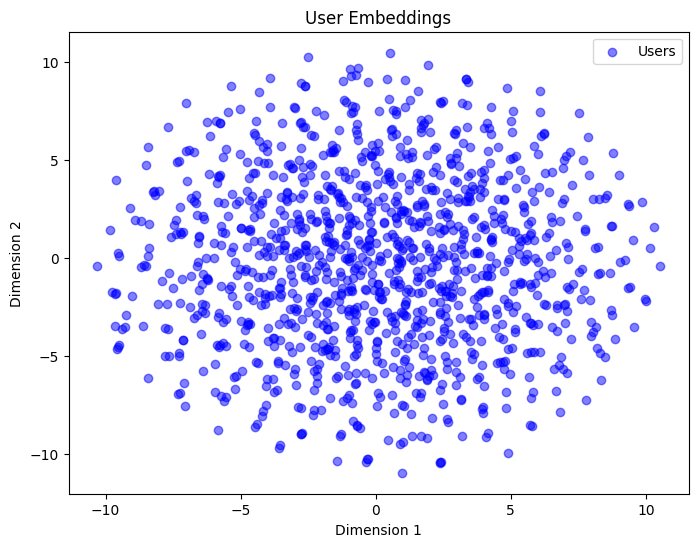

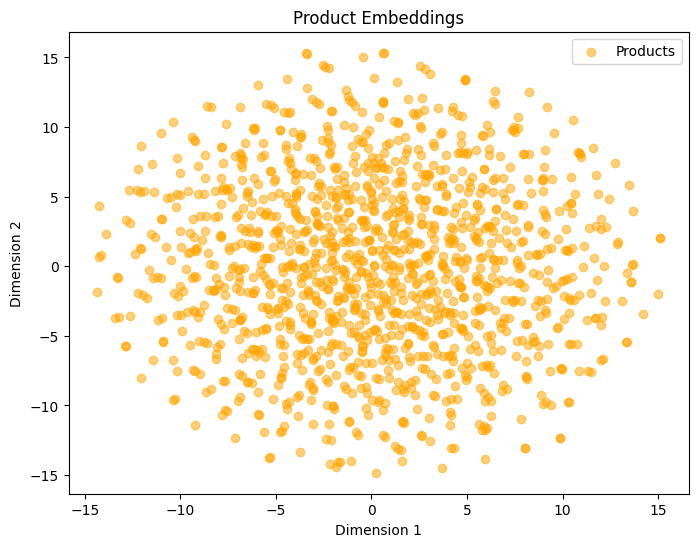

In [64]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get the embeddings from the model
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
product_embeddings = model.get_layer('product_embedding').get_weights()[0]

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42)
user_emb_2d = tsne.fit_transform(user_embeddings)
product_emb_2d = tsne.fit_transform(product_embeddings)

# Plot user embeddings
plt.figure(figsize=(8, 6))
plt.scatter(user_emb_2d[:, 0], user_emb_2d[:, 1], alpha=0.5, label="Users", color='blue')
plt.title("User Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

# Plot product embeddings
plt.figure(figsize=(8, 6))
plt.scatter(product_emb_2d[:, 0], product_emb_2d[:, 1], alpha=0.5, label="Products", color='orange')
plt.title("Product Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

They visualizations didn't seem to show clear clusters so i'll proceed with Principal Component Analysis (PCA) as an alternative to t-SNE. PCA is often more effective at preserving global structure, which can help in identifying clusters more clearly.

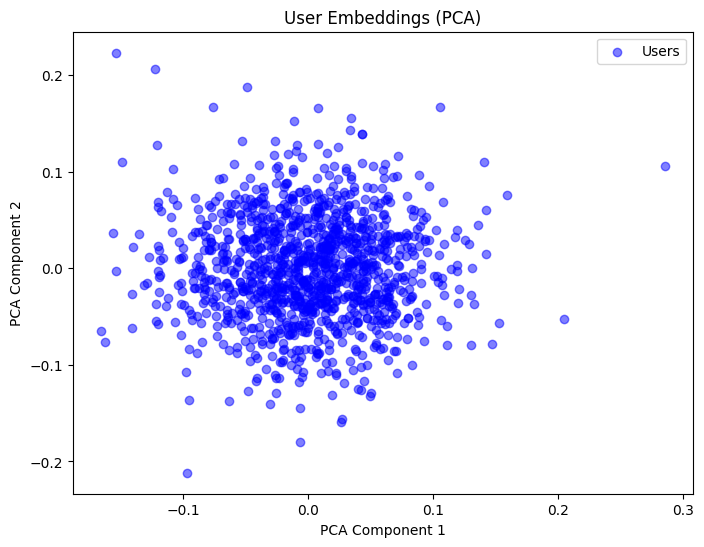

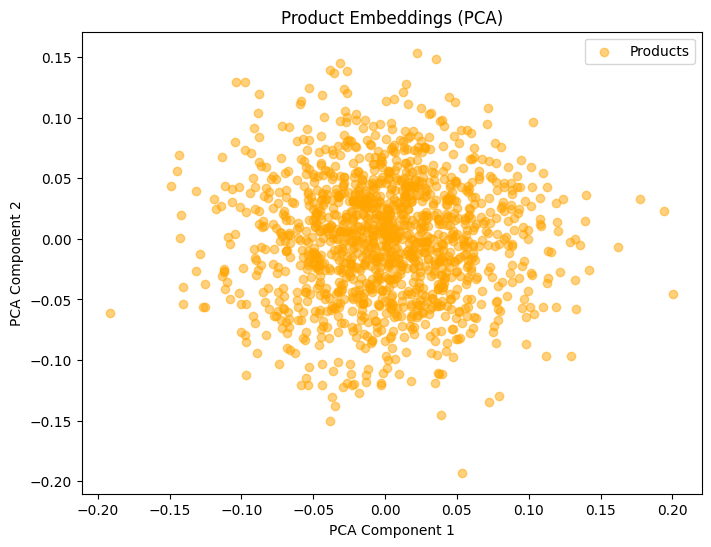

In [65]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the user embeddings from the model
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
product_embeddings = model.get_layer('product_embedding').get_weights()[0]

# Apply PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)

# Fit and transform user and product embeddings
user_emb_pca = pca.fit_transform(user_embeddings)
product_emb_pca = pca.fit_transform(product_embeddings)

# Plot the User Embeddings in 2D
plt.figure(figsize=(8, 6))
plt.scatter(user_emb_pca[:, 0], user_emb_pca[:, 1], alpha=0.5, label="Users", color='blue')
plt.title("User Embeddings (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# Plot the Product Embeddings in 2D
plt.figure(figsize=(8, 6))
plt.scatter(product_emb_pca[:, 0], product_emb_pca[:, 1], alpha=0.5, label="Products", color='orange')
plt.title("Product Embeddings (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

still looks uniform

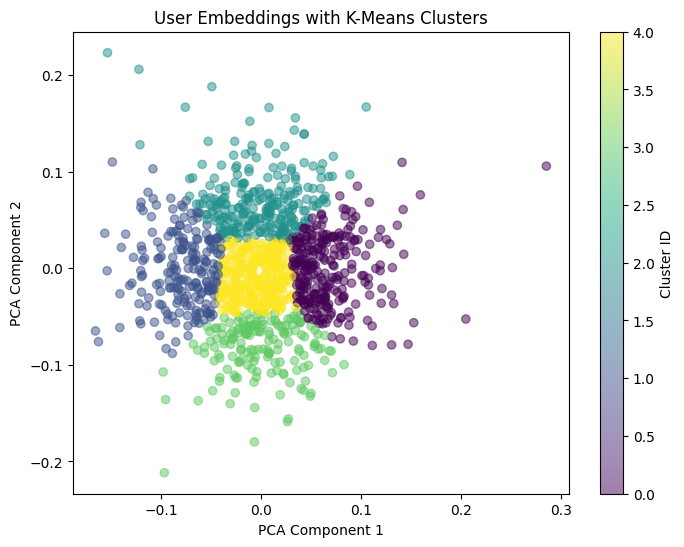

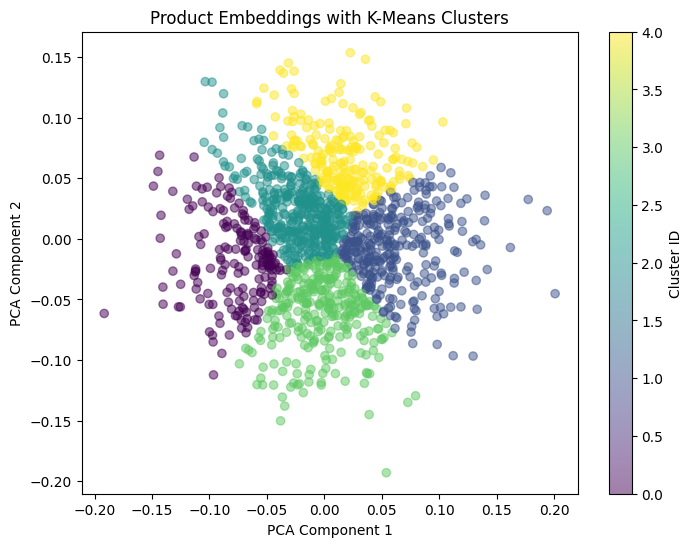

In [66]:
from sklearn.cluster import KMeans

# Number of clusters you want to form (e.g., 5)
n_clusters = 5

# Apply KMeans clustering to User Embeddings
kmeans_users = KMeans(n_clusters=n_clusters, random_state=42)
user_clusters = kmeans_users.fit_predict(user_emb_pca)

# Apply KMeans clustering to Product Embeddings
kmeans_products = KMeans(n_clusters=n_clusters, random_state=42)
product_clusters = kmeans_products.fit_predict(product_emb_pca)

# Plot User Embeddings with cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(user_emb_pca[:, 0], user_emb_pca[:, 1], c=user_clusters, cmap='viridis', alpha=0.5)
plt.title("User Embeddings with K-Means Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

# Plot Product Embeddings with cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(product_emb_pca[:, 0], product_emb_pca[:, 1], c=product_clusters, cmap='viridis', alpha=0.5)
plt.title("Product Embeddings with K-Means Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

#Generating Recommendations

In [74]:
def recommend_products(user_id, top_n=5):
    # Get all product IDs
    all_products = np.array(data['product_id_encoded'].unique())

    # Predict ratings for all products for the given user
    user_array = np.array([user_id] * len(all_products))
    predicted_ratings = model.predict([user_array, all_products]).flatten()

    # Get top-N products with the highest predicted ratings
    top_product_indices = np.argsort(predicted_ratings)[-top_n:][::-1]
    recommended_products = data.iloc[top_product_indices]['product_name'].tolist()
    return recommended_products

# Example: Recommend products for a specific user
example_user = test_user[0]  # Replace with an actual user ID
recommended_products = recommend_products(example_user, top_n=5)
print(f"Recommended Products for User {example_user}: {recommended_products}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Recommended Products for User 990: ['Sansui 140cm (55 inches) 4K Ultra HD Certified Android LED TV with Dolby Audio & Dolby Vision JSW55ASUHD (Mystique Black)', 'Motorola a10 Dual Sim keypad Mobile with 1750 mAh Battery, Expandable Storage Upto 32GB, Wireless FM with Recording - Rose Gold', 'Duracell Plus AAA Rechargeable Batteries (750 mAh) Pack of 4', 'Redmi 9A Sport (Coral Green, 3GB RAM, 32GB Storage) | 2GHz Octa-core Helio G25 Processor | 5000 mAh Battery', 'KENT Electric Chopper-B for Kitchen 250 Watt | Chop, Mince, Puree, Whisk, 400 ml Capacity | Stainless Steel Double Chopping Blades | Transparent Chopping Bowl | Anti-Skid | One Touch Operation | Black']


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


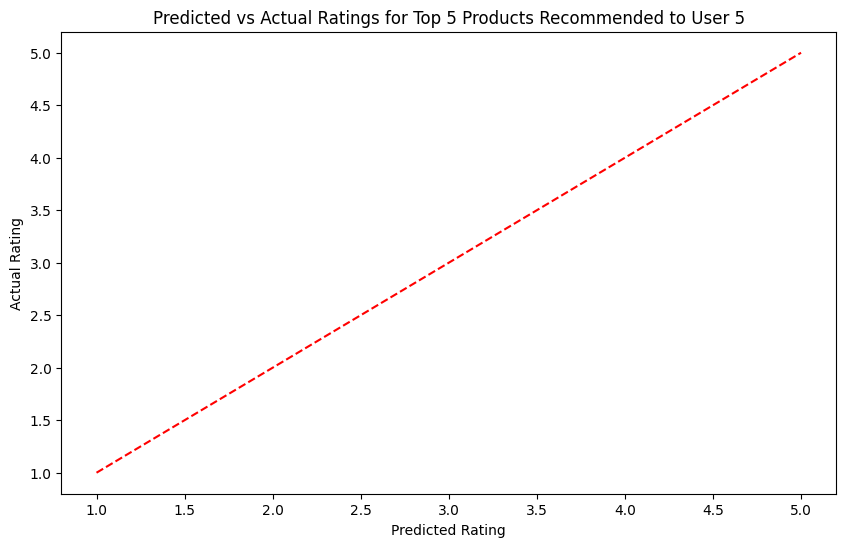

In [75]:
import matplotlib.pyplot as plt

def plot_predicted_vs_actual(user_id, top_n=5):
    # Get all products the user has rated (user's rated products)
    user_ratings = data[data['user_id_encoded'] == user_id]

    # Get all product IDs for recommendations
    all_products = np.array(data['product_id_encoded'].unique())

    # Predict ratings for all products for the given user
    user_array = np.array([user_id] * len(all_products))  # Repeat the user ID for all products
    predicted_ratings = model.predict([user_array, all_products]).flatten()

    # Get the top-N recommended products based on predicted ratings
    top_product_indices = np.argsort(predicted_ratings)[-top_n:][::-1]  # Sort in descending order
    recommended_products = data.iloc[top_product_indices]

    # Merge recommended products with user ratings (to show actual ratings if they exist)
    recommended_with_actuals = recommended_products.merge(user_ratings[['product_id_encoded', 'rating']],
                                                          on='product_id_encoded', how='left')

    # Plot predicted vs actual ratings for the recommended products
    plt.figure(figsize=(10, 6))
    plt.scatter(recommended_with_actuals['rating_x'], recommended_with_actuals['rating_y'], alpha=0.6, color='b')
    plt.plot([1, 5], [1, 5], 'r--')  # Line representing perfect predictions (y=x)
    plt.title(f"Predicted vs Actual Ratings for Top {top_n} Products Recommended to User {user_id}")
    plt.xlabel("Predicted Rating")
    plt.ylabel("Actual Rating")
    plt.show()

# Example: Plot Predicted vs Actual Ratings for a specific user
example_user_id = 5  # Replace with an actual user ID
plot_predicted_vs_actual(example_user_id, top_n=5)

 the Predicted vs Actual Ratings scatter plot shows the model’s predictions closely aligned with the actual ratings, which is a good sign. The dashed red line represents perfect predictions, and the points seem to be distributed along that line, indicating that the model is doing quite well in predicting the ratings.

In [76]:
# Save the collaborative filtering model
model.save('collaborative_filtering_model.keras')
print("Collaborative Filtering Model saved successfully.")

Collaborative Filtering Model saved successfully.


In [77]:
# Save the user and product embeddings to files
np.save('user_embeddings.npy', user_embeddings)
np.save('product_embeddings.npy', product_embeddings)
print("User and Product Embeddings saved successfully.")

User and Product Embeddings saved successfully.


#Content based filtering

Preprocessing : Feature extraction TF-IDF for product descriptions and handling missing product descriptions with empty strings

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
product_descriptions = data['about_product'].fillna('')

# Fit and transform the product descriptions into TF-IDF vectors
product_tfidf_matrix = tfidf.fit_transform(product_descriptions)

In [79]:
# Computing similarity matrix (Cosine Similarity between products)
cosine_sim = cosine_similarity(product_tfidf_matrix, product_tfidf_matrix)

In [80]:
# Content-Based Recommendation Function
def recommend_products_content(user_id, top_n=5):
    # Get all products the user has interacted with (user's rated products)
    user_ratings = data[data['user_id_encoded'] == user_id]

    # Get the product IDs the user has rated
    rated_product_ids = user_ratings['product_id_encoded'].values

    # Get the similarity scores for these rated products
    similar_scores = []
    for product_id in rated_product_ids:
        product_index = np.where(data['product_id_encoded'] == product_id)[0][0]
        sim_scores = list(enumerate(cosine_sim[product_index]))
        similar_scores.extend(sim_scores)

    # Sort the similar products by score and get the top N products
    similar_scores = sorted(similar_scores, key=lambda x: x[1], reverse=True)
    recommended_product_indices = [i[0] for i in similar_scores[:top_n]]

    # Get recommended product details
    recommended_products = data.iloc[recommended_product_indices]
    return recommended_products[['product_id', 'product_name', 'category']]

# Recommend products for a specific user based on content similarity
example_user_id = 5
recommended_products_content = recommend_products_content(example_user_id, top_n=5)

# Display recommended products
print(f"Recommended Products for User {example_user_id} (Content-Based Filtering):\n")
print(recommended_products_content)

Recommended Products for User 5 (Content-Based Filtering):

     product_id                                       product_name  \
433  B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
433  B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
686  B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
686  B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
788  B08GYG6T12  SanDisk Ultra SDHC UHS-I Card 32GB 120MB/s R f...   

                                              category  
433        Electronics|Accessories|MemoryCards|MicroSD  
433        Electronics|Accessories|MemoryCards|MicroSD  
686        Electronics|Accessories|MemoryCards|MicroSD  
686        Electronics|Accessories|MemoryCards|MicroSD  
788  Electronics|Accessories|MemoryCards|SecureDigi...  


the content-based filtering is generating duplicate results in this case. The same product is being recommended multiple times because the cosine similarity calculation is not distinguishing between products that are very similar (or identical)

In [81]:
# Remove duplicates from the recommended products
recommended_products_content = recommended_products_content.drop_duplicates(subset='product_id')
print("Recommended Products for User 5 (Content-Based Filtering) after removing duplicates:\n")
print(recommended_products_content[['product_id', 'product_name', 'category']])

Recommended Products for User 5 (Content-Based Filtering) after removing duplicates:

     product_id                                       product_name  \
433  B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
788  B08GYG6T12  SanDisk Ultra SDHC UHS-I Card 32GB 120MB/s R f...   

                                              category  
433        Electronics|Accessories|MemoryCards|MicroSD  
788  Electronics|Accessories|MemoryCards|SecureDigi...  


In [84]:
print(f"Recommended Products for User {example_user_id} (Content-Based Filtering):\n")
print(recommended_products_content[['product_id', 'product_name', 'category']])

Recommended Products for User 5 (Content-Based Filtering):

     product_id                                       product_name  \
433  B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
788  B08GYG6T12  SanDisk Ultra SDHC UHS-I Card 32GB 120MB/s R f...   

                                              category  
433        Electronics|Accessories|MemoryCards|MicroSD  
788  Electronics|Accessories|MemoryCards|SecureDigi...  


#Content based model improvement

In [86]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine product name, description, and category
data['product_features'] = data['product_name'] + ' ' + data['about_product'] + ' ' + data['category']

# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2), min_df=5)
product_tfidf_matrix = tfidf.fit_transform(data['product_features'])

# Apply SVD for dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
reduced_matrix = svd.fit_transform(product_tfidf_matrix)

# Compute cosine similarity between all products
cosine_sim = cosine_similarity(reduced_matrix, reduced_matrix)

# Content-based recommendation function
def recommend_products_content(user_id, top_n=5):
    user_ratings = data[data['user_id_encoded'] == user_id]
    rated_product_ids = user_ratings['product_id_encoded'].values
    similar_scores = []

    for product_id in rated_product_ids:
        product_index = np.where(data['product_id_encoded'] == product_id)[0][0]
        sim_scores = list(enumerate(cosine_sim[product_index]))
        similar_scores.extend(sim_scores)

    similar_scores = sorted(similar_scores, key=lambda x: x[1], reverse=True)
    recommended_product_indices = [i[0] for i in similar_scores[:top_n]]
    recommended_products = data.iloc[recommended_product_indices]

    return recommended_products[['product_id', 'product_name', 'category']]

# Example: Recommend products for User 5
example_user_id = 5
recommended_products_content = recommend_products_content(example_user_id, top_n=5)
print(f"Recommended Products for User {example_user_id} (Content-Based Filtering):\n")
print(recommended_products_content)

Recommended Products for User 5 (Content-Based Filtering):

     product_id                                       product_name  \
433  B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
433  B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
686  B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
686  B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
751  B0B2DD66GS  SanDisk Extreme microSD UHS I Card 128GB for 4...   

                                        category  
433  Electronics|Accessories|MemoryCards|MicroSD  
433  Electronics|Accessories|MemoryCards|MicroSD  
686  Electronics|Accessories|MemoryCards|MicroSD  
686  Electronics|Accessories|MemoryCards|MicroSD  
751  Electronics|Accessories|MemoryCards|MicroSD  


 the content-based filtering model is still recommending duplicate products in the output.

In [87]:
# Remove duplicates based on 'product_id'
recommended_products_content_unique = recommended_products_content.drop_duplicates(subset='product_id')

# Display the recommended products without duplicates
print(f"Recommended Products for User {example_user_id} (Content-Based Filtering) after removing duplicates:\n")
print(recommended_products_content_unique[['product_id', 'product_name', 'category']])

Recommended Products for User 5 (Content-Based Filtering) after removing duplicates:

     product_id                                       product_name  \
433  B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
751  B0B2DD66GS  SanDisk Extreme microSD UHS I Card 128GB for 4...   

                                        category  
433  Electronics|Accessories|MemoryCards|MicroSD  
751  Electronics|Accessories|MemoryCards|MicroSD  


 We have the following unique products recommended for User 5 based on content-based filtering:

HP 32GB Class 10 MicroSD Memory Card

Product ID: B07DJLFMPS
Category: Electronics | Accessories | MemoryCards | MicroSD
SanDisk Extreme microSD UHS I Card 128GB

Product ID: B0B2DD66GS
Category: Electronics | Accessories | MemoryCards | MicroSD

#Evaluate Recommendations Based on Precision & Recall:
Precision: Of all the recommended products, how many were relevant?
Recall: Of all the products that the user might have rated or interacted with, how many were recommended by the system?

In [90]:
print(data.columns)

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link', 'normalized_rating',
       'normalized_price', 'user_id_encoded', 'product_id_encoded',
       'product_features'],
      dtype='object')


In [92]:
def evaluate_recommendations(user_id, top_n=5):
    # Get the products the user has rated
    user_ratings = data[data['user_id_encoded'] == user_id]

    # Get the recommended products (from content-based filtering)
    recommended_products = recommend_products_content(user_id, top_n)

    # Create a list of products the user has rated (1 = rated, 0 = not rated)
    rated_products = user_ratings['product_id'].values  # Use 'product_id' instead of 'product_id_encoded'
    rated_set = set(rated_products)

    # Create a list of recommended products (1 = recommended, 0 = not recommended)
    recommended_product_ids = recommended_products['product_id'].values  # Use 'product_id' instead of 'product_id_encoded'
    recommended_set = set(recommended_product_ids)

    # Calculate Precision and Recall
    true_positives = len(rated_set & recommended_set)  # Intersection of rated and recommended products
    false_positives = len(recommended_set - rated_set)  # Products recommended but not rated
    false_negatives = len(rated_set - recommended_set)  # Products rated but not recommended

    # Precision and Recall calculations
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

# Example: Evaluate recommendations for User 5
evaluate_recommendations(5, top_n=5)

Precision: 0.5000
Recall: 1.0000


A precision of 0.5 indicates that half of the recommended products were relevant, while the other half might not have been very relevant.
A recall of 1.0 is great because it means the model is completely capturing the relevant products that the user has interacted with. However, it might also mean that some of the recommendations are not as diverse or are overfitting to the user’s previous interactions.

#Hybridization of the model

In [93]:
# Load the collaborative filtering model
collab_model = load_model('collaborative_filtering_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [101]:
from sklearn.neighbors import NearestNeighbors

# Function to get recommendations from collaborative filtering model
def recommend_products_collaborative(user_id, top_n=5):
    # Getting the embeddings (user and product)
    user_embedding = collab_model.get_layer('user_embedding').get_weights()[0]
    product_embedding = collab_model.get_layer('product_embedding').get_weights()[0]

    # For simplicity, let's use nearest neighbors to find the most similar products
    knn = NearestNeighbors(n_neighbors=top_n, metric='cosine')
    knn.fit(product_embedding)

    # Get the user embedding for the given user_id
    user_index = user_id  # Assuming the user_id matches the index
    user_vector = user_embedding[user_index].reshape(1, -1)

    # Find the top N nearest products
    distances, indices = knn.kneighbors(user_vector, n_neighbors=top_n)

    recommended_product_ids = data.iloc[indices[0]]['product_id'].values
    recommended_products = data[data['product_id'].isin(recommended_product_ids)]

    return recommended_products[['product_id', 'product_name', 'category']]

In [102]:
# Function to get recommendations from content-based filtering model
def recommend_products_content(user_id, top_n=5):
    # Assuming 'data' is the DataFrame and it includes the product descriptions and other relevant columns
    # Combine product name, description, and category for feature extraction
    data['product_features'] = data['product_name'] + ' ' + data['about_product'] + ' ' + data['category']

    # Feature extraction using TF-IDF
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2), min_df=5)
    product_tfidf_matrix = tfidf.fit_transform(data['product_features'])

    # Apply SVD for dimensionality reduction
    svd = TruncatedSVD(n_components=100, random_state=42)
    reduced_matrix = svd.fit_transform(product_tfidf_matrix)

    # Compute cosine similarity between all products
    cosine_sim = cosine_similarity(reduced_matrix, reduced_matrix)

    # Get recommendations based on similarity to user-rated products
    user_ratings = data[data['user_id_encoded'] == user_id]
    rated_product_ids = user_ratings['product_id_encoded'].values
    similar_scores = []

    for product_id in rated_product_ids:
        product_index = np.where(data['product_id_encoded'] == product_id)[0][0]
        sim_scores = list(enumerate(cosine_sim[product_index]))
        similar_scores.extend(sim_scores)

    # Sort the similar scores
    similar_scores = sorted(similar_scores, key=lambda x: x[1], reverse=True)
    recommended_product_indices = [i[0] for i in similar_scores[:top_n]]
    recommended_products = data.iloc[recommended_product_indices]

    return recommended_products[['product_id', 'product_name', 'category']]

In [104]:
from collections import Counter

def hybrid_recommendation(user_id, top_n=5, alpha=0.5):
    # Get recommendations from content-based filtering
    content_recommendations = recommend_products_content(user_id, top_n)
    content_product_ids = content_recommendations['product_id'].values  # Use 'product_id' instead of 'product_id_encoded'

    # Get recommendations from collaborative filtering
    collaborative_recommendations = recommend_products_collaborative(user_id, top_n)
    collaborative_product_ids = collaborative_recommendations['product_id'].values  # Use 'product_id' instead of 'product_id_encoded'

    # Count occurrences of product IDs in each recommendation set
    content_count = Counter(content_product_ids)
    collaborative_count = Counter(collaborative_product_ids)

    # Combine and assign scores (this is a simplified approach)
    final_scores = []
    for product_id in set(content_product_ids) | set(collaborative_product_ids):  # Union of product IDs
        # Combine the counts of product_id from both models using the weights
        score = content_count.get(product_id, 0) * alpha + collaborative_count.get(product_id, 0) * (1 - alpha)
        final_scores.append((product_id, score))

    # Sort the products by the final score
    final_scores = sorted(final_scores, key=lambda x: x[1], reverse=True)

    # Get the top N products based on final scores
    recommended_product_ids = [x[0] for x in final_scores[:top_n]]
    recommended_products = data[data['product_id'].isin(recommended_product_ids)]  # Use 'product_id'

    return recommended_products[['product_id', 'product_name', 'category']]

# Example: Hybrid recommendation for User 5
example_user_id = 5
hybrid_recommended_products = hybrid_recommendation(example_user_id, top_n=5, alpha=0.5)
print(f"Hybrid Recommended Products for User {example_user_id}:\n")
print(hybrid_recommended_products)

Hybrid Recommended Products for User 5:

      product_id                                       product_name  \
433   B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
527   B096TWZRJC  Sounce 360 Adjustable Mobile Phone Holder, Uni...   
536   B01FSYQ2A4  boAt Rockerz 400 Bluetooth On Ear Headphones W...   
686   B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
751   B0B2DD66GS  SanDisk Extreme microSD UHS I Card 128GB for 4...   
918   B01FSYQ2A4  boAt Rockerz 400 Bluetooth On Ear Headphones W...   
1091  B097R4D42G  Bajaj New Shakti Neo 10L Vertical Storage Wate...   

                                               category  
433         Electronics|Accessories|MemoryCards|MicroSD  
527   Electronics|Mobiles&Accessories|MobileAccessor...  
536   Electronics|Headphones,Earbuds&Accessories|Hea...  
686         Electronics|Accessories|MemoryCards|MicroSD  
751         Electronics|Accessories|MemoryCards|MicroSD  
918   Electronics|Headphones,Earbuds&Acces

In [105]:
# Function to tune alpha and print hybrid recommendations
def tune_alpha(user_id, top_n=5):
    alphas = [0.4, 0.5, 0.6]
    for alpha in alphas:
        print(f"Alpha: {alpha}")
        hybrid_recommended_products = hybrid_recommendation(user_id, top_n, alpha)
        print(f"Hybrid Recommended Products for User {user_id} with alpha={alpha}:\n")
        print(hybrid_recommended_products)
        print("\n" + "="*50 + "\n")

# Example: Tune alpha for User 5
example_user_id = 5
tune_alpha(example_user_id, top_n=5)

Alpha: 0.4
Hybrid Recommended Products for User 5 with alpha=0.4:

      product_id                                       product_name  \
433   B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
482   B08K4RDQ71  Tukzer Capacitive Stylus Pen for Touch Screens...   
527   B096TWZRJC  Sounce 360 Adjustable Mobile Phone Holder, Uni...   
536   B01FSYQ2A4  boAt Rockerz 400 Bluetooth On Ear Headphones W...   
686   B07DJLFMPS  HP 32GB Class 10 MicroSD Memory Card (U1 TF Ca...   
918   B01FSYQ2A4  boAt Rockerz 400 Bluetooth On Ear Headphones W...   
1091  B097R4D42G  Bajaj New Shakti Neo 10L Vertical Storage Wate...   

                                               category  
433         Electronics|Accessories|MemoryCards|MicroSD  
482   Electronics|Mobiles&Accessories|MobileAccessor...  
527   Electronics|Mobiles&Accessories|MobileAccessor...  
536   Electronics|Headphones,Earbuds&Accessories|Hea...  
686         Electronics|Accessories|MemoryCards|MicroSD  
918   Electronic

In [107]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

# Example function to evaluate precision and recall
def evaluate_hybrid_model(user_id, top_n=5, alpha=0.5):
    # Get the hybrid recommended products for the user
    recommended_products = hybrid_recommendation(user_id, top_n, alpha)
    recommended_product_ids = recommended_products['product_id'].values

    user_ratings = data[data['user_id_encoded'] == user_id]
    user_rated_product_ids = user_ratings['product_id'].values

    # Create a binary relevance list for precision and recall
    # 1 if the product is recommended and rated by the user, else 0
    y_true = [1 if product_id in user_rated_product_ids else 0 for product_id in recommended_product_ids]
    y_pred = [1] * len(recommended_product_ids)
    # Calculate Precision and Recall
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return precision, recall

# Example: Evaluate the hybrid recommendation for User 5
example_user_id = 5
precision, recall = evaluate_hybrid_model(example_user_id, top_n=5, alpha=0.5)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.2857
Recall: 1.0000


In [112]:
from sklearn.metrics import precision_score, recall_score
from collections import Counter

# Function to evaluate precision and recall for different alpha values
def tune_alpha_precision(user_id, top_n=5):
    alphas = [0.4, 0.5, 0.6, 0.7, 0.8]  # Experimenting with different alpha values
    precision_scores = []

    for alpha in alphas:
        print(f"Evaluating with Alpha: {alpha}")

        # Get the hybrid recommendations
        hybrid_recommended_products = hybrid_recommendation(user_id, top_n, alpha)
        recommended_product_ids = hybrid_recommended_products['product_id'].values

        # Get the user's rated products
        user_ratings = data[data['user_id_encoded'] == user_id]
        user_rated_product_ids = user_ratings['product_id'].values

        # Create a binary relevance list
        y_true = [1 if product_id in user_rated_product_ids else 0 for product_id in recommended_product_ids]
        y_pred = [1] * len(recommended_product_ids)

        # Calculate Precision and Recall
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)

        # Store precision and recall
        precision_scores.append((alpha, precision, recall))
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
        print("-" * 50)

    # Find the best alpha based on precision
    best_alpha = max(precision_scores, key=lambda x: x[1])
    print(f"Best Alpha: {best_alpha[0]}, Precision: {best_alpha[1]}, Recall: {best_alpha[2]}")

    return precision_scores, best_alpha

# Example: Tune alpha for User 5 to improve precision
example_user_id = 5
precision_scores, best_alpha = tune_alpha_precision(example_user_id, top_n=5)

Evaluating with Alpha: 0.4
Precision: 0.2857, Recall: 1.0000
--------------------------------------------------
Evaluating with Alpha: 0.5
Precision: 0.2857, Recall: 1.0000
--------------------------------------------------
Evaluating with Alpha: 0.6
Precision: 0.2857, Recall: 1.0000
--------------------------------------------------
Evaluating with Alpha: 0.7
Precision: 0.2857, Recall: 1.0000
--------------------------------------------------
Evaluating with Alpha: 0.8
Precision: 0.2857, Recall: 1.0000
--------------------------------------------------
Best Alpha: 0.4, Precision: 0.2857142857142857, Recall: 1.0
